In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)    

from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import config
import torch

In [2]:
from dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
X, y = dataset.get(dataframe=False)

In [3]:
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset 
from torchvision import transforms as torchTransforms

class AuxDataset(Dataset):
    def __init__(self, dataset_dir, transform=torchTransforms.Compose([torchTransforms.ToTensor()])):
        super(AuxDataset, self).__init__()
        dataset = DermaDataset(dataset_dir)
        self.X, self.y = dataset.get(dataframe=False)
        self.X, self.y = torch.tensor(self.X, dtype=torch.float), torch.tensor(self.y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

dataset = AuxDataset(dataset_dir, None)
val_size = 512
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-val_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False)

In [4]:
from Sparse import KWinners
from HySpecLab.feature_selection.nn import KFeatureSelector
from torch import nn

# model = nn.Sequential(*[
#     nn.Conv1d(1,1,1, bias=False),
#     nn.Flatten(1),
#     KWinners(116, 50),    
#     nn.Linear(116, 256),
#     nn.ReLU(),
#     nn.Linear(256, 64),
#     nn.ReLU(),
#     nn.Linear(64, 2),
# ])

n_bands = 116
# model = nn.Sequential(*[
#     nn.Conv1d(n_bands,n_bands,1, groups=n_bands, bias=False),
#     nn.Flatten(1),
#     KWinners(n_bands, 25),
#     nn.Linear(n_bands, 256, bias=True),
#     nn.Dropout(0.25),
#     nn.ReLU(),
#     nn.Linear(256, n_bands, bias=True),
#     nn.Sigmoid()
# ])

model = nn.Sequential(*[
    KFeatureSelector(n_bands, 25),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.Sigmoid()
])

In [ ]:
from tqdm import tqdm
from HySpecLab.metrics import TotalVariationalReg

n_epoch = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=.6)
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
reg = TotalVariationalReg()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

model.train()
for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input[:,:,None])
        # loss = criterion(out, target)
        # loss = criterion(out, input) + 1e-3*torch.diff(out, 1).abs().mean() # Including total variation regularization
        # reg = torch.diff(out, 1).abs().sum(axis=1).mean()
        reg_loss = reg(out)
        loss = criterion(out, input) + 1e-6*reg_loss

        if idx % 150 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:,None].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::64,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::64,:].T)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    input = input.to(device)
    out = model[:3](input[:,:, None])
plt.plot(out[6].detach().cpu().numpy().T)
plt.show()

In [ ]:
a = model[0].model[0].weight.data.cpu().flatten().numpy()
zeros = np.where(a<=0)[0]
zeros.shape

In [ ]:
a = model[0].model[0].weight.data.cpu().flatten().numpy()
plt.plot(a)
plt.show()

len(a[a>0])

# Test with Cross-Correlation

In [26]:
from HySpecLab.metrics import NCC

In [38]:
from Sparse import KWinners
n_bands = 116
model = nn.Sequential(*[
    nn.Conv1d(n_bands,n_bands,1,groups=n_bands,bias=False),
    nn.Flatten(1),
    KWinners(n_bands, 25),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.Sigmoid()
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

In [39]:
from tqdm import tqdm
from HySpecLab.metrics import TotalVariationalReg

n_epoch = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=.9, weight_decay=1e-6)
criterion = NCC()
reg = TotalVariationalReg()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

model.train()
for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input[:,:,None])
        # reg_loss = reg(out)
        reg_loss = 0
        loss = criterion(out, input) + 1e-6*reg_loss

        if idx % 150 == 0:
           epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 50/50 [00:51<00:00,  1.03s/epoch, tls=0.0069]


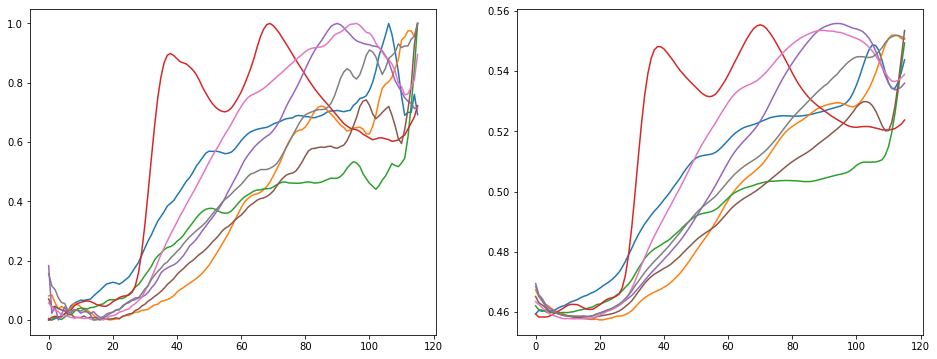

In [40]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:,None].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::64,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::64,:].T)
plt.show()

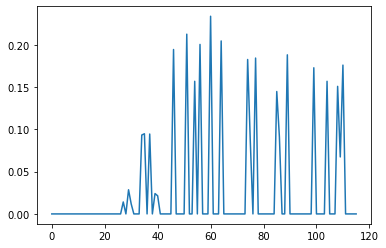

In [41]:
model.eval()
with torch.no_grad():
    input = input.to(device)
    out = model[:3](input[:,:, None])
plt.plot(out[6].detach().cpu().numpy().T)
plt.show()

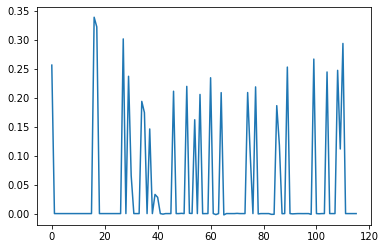

In [42]:
a = model[0].weight.data.cpu().flatten().numpy()
plt.plot(a)
plt.show()

In [43]:
model[0].weight.data.cpu().flatten()
len(a[a<=0])
len(a[a>0])

76

# Sparse with KL Div

In [ ]:
from torch import nn
from torch.autograd import Function
import torch

def kl_divergence_gradient(p: float, q: torch.Tensor, apply_sigmoid = True) -> torch.Tensor:
    r'''
        Compute the gradient of the KL divergence with respect to the input tensor.

        Parameters
        ----------
            p: float
                Sparsity parameter, typically a small value close to zero (say p=0.05).
            
            q: torch.Tensor, shape (batch_size, n_features)
                Input tensor which will be penalized deviating significantly from p.
    '''
    # check if tensor belong to a convolutional output or not
    dim = 2 if len(q.shape) == 4 else 1

    q = torch.sigmoid(q) if apply_sigmoid else q # sigmoid because we need the probability distributions
    q_grad = q * (1-q) if apply_sigmoid else 1

    rho_hat = q.flatten(dim)
    rho = torch.ones_like(rho_hat).to(q.device) * p

    eps = 1e-12
    kl_grad = -(rho_hat - rho)/((rho_hat-1)*rho_hat + eps)

    return q_grad * kl_grad 


class FeatureSelectorFunction(Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input: torch.Tensor, weight: torch.Tensor, sparse_rate: float) -> torch.Tensor:
        ctx.save_for_backward(input, weight, sparse_rate)
        output = input * weight
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, sparse_rate = ctx.saved_tensors
        grad_input = grad_weight = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output * weight
            # print('Grad. Input: {}'.format(grad_input))
        if ctx.needs_input_grad[1]:
            grad_weight = (grad_output * input).sum(dim=0).reshape(weight.shape) # Dot product
            sparse_grad = (kl_divergence_gradient(0.05, input * weight, apply_sigmoid=True) * input).sum(dim=0).reshape(weight.shape)
            grad_weight += sparse_rate*sparse_grad
            # print('Grad. Weight: {}'.format(grad_weight))

        return grad_input, grad_weight, None


class FeatureSelector(nn.Module):
    def __init__(self, n_features:int, sparse_rate: float):
        super(FeatureSelector, self).__init__()  
        self.sparse_rate = nn.Parameter(torch.tensor(sparse_rate), requires_grad = False)
        # self.weight = nn.Parameter(torch.full((n_features,), 1/n_features), requires_grad=True)
        self.weight = nn.Parameter(torch.rand((n_features,), requires_grad=True))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return FeatureSelectorFunction.apply(input, self.weight, self.sparse_rate)

In [168]:
from HySpecLab.feature_selection.nn import SparseWeightedFeatureSelector
n_bands = 116
model = nn.Sequential(*[
    SparseWeightedFeatureSelector(n_bands, 1e-5),
    nn.ReLU(),
    nn.Linear(n_bands, 64, bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, n_bands, bias=True),
    nn.Sigmoid(),
])

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

In [169]:
from HySpecLab.metrics import NCC, TotalVariationalReg
from tqdm import tqdm

n_epoch = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = NCC()
# criterion = nn.MSELoss()
reg = TotalVariationalReg()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

model.train()
for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input[:,:])
        reg_loss = reg(out)
        loss = criterion(out, input) + 1e-6*reg_loss

        if idx % 150 == 0:
           epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [00:43<00:00,  2.31epoch/s, tls=0.0079]


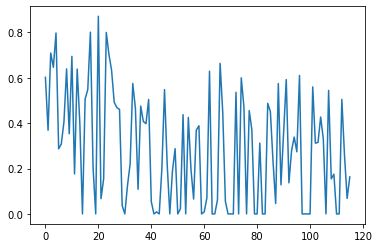

89


In [170]:
weight_data = model[0].weight.data.cpu().numpy()
weight_data_no_negative = weight_data.copy()
weight_data_no_negative[weight_data_no_negative<0] = 0
plt.plot(weight_data_no_negative)
plt.show()

print(len(weight_data[weight_data > 0]))

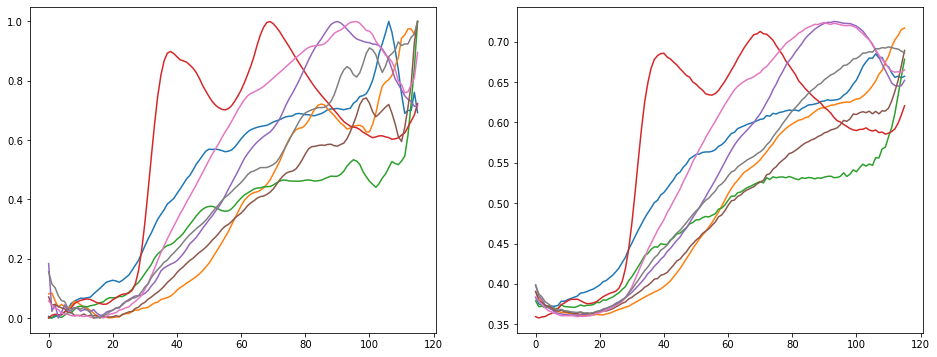

In [171]:
model.eval()
with torch.no_grad():
    input, _ = next(iter(val_loader))
    out = model(input[:,:].to(device))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(input.detach().cpu().numpy()[::64,:].T)
plt.subplot(1,2,2)
plt.plot(out.detach().cpu().numpy()[::64,:].T)
plt.show()

In [163]:
weight_data.mean()

-0.923362